## Imports

In [3]:
try:
    from astra.torch.models import ResNetClassifier
except:
    %pip install git+https://github.com/sustainability-lab/ASTRA

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torchsummary
from tqdm import tqdm

import umap

# ASTRA
from astra.torch.data import load_cifar_10
from astra.torch.utils import train_fn
from astra.torch.models import ResNetClassifier

# Netron, ONNX for model visualization
import netron
import onnx

import copy


/home/nipun.batra/miniforge3/lib/python3.9/site-packages/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/nipun.batra/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Dataset

In [6]:
dataset = load_cifar_10()
dataset

Files already downloaded and verified
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
            

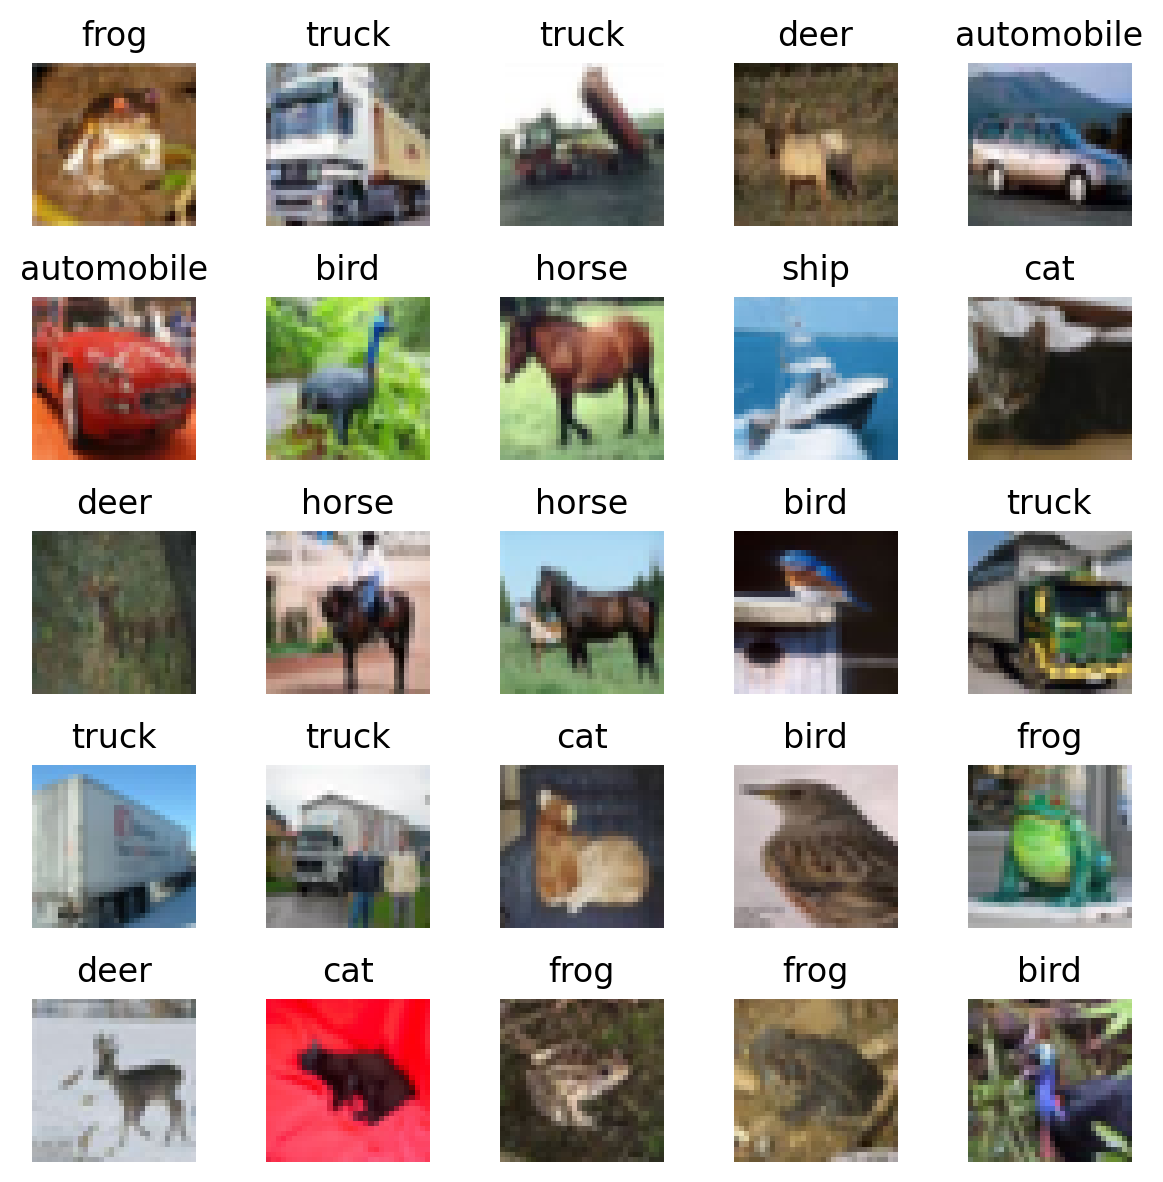

In [7]:
# Plot some images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(torch.einsum("chw->hwc", dataset.data[i].cpu()))
    plt.axis('off')
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()


### Data splitting

In [8]:
n_train = 1000
n_test = 20000

X = dataset.data
y = dataset.targets

print(X.shape)
print(X.shape, X.dtype)
print(X.min(), X.max())
print(y.shape, y.dtype)

torch.Size([60000, 3, 32, 32])
torch.Size([60000, 3, 32, 32]) torch.float32
tensor(0.) tensor(1.)
torch.Size([60000]) torch.int64


In [9]:
torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:]
print(f"Length of train set: {len(train_idx)}")
print(f"Length of pool set: {len(pool_idx)}")
print(f"Length of test set: {len(test_idx)}")

Length of train set: 1000
Length of pool set: 39000
Length of test set: 20000


In [10]:
resnet = ResNetClassifier(models.resnet18, models.ResNet18_Weights.DEFAULT, n_classes=10).to(device)

/home/nipun.batra/miniforge3/lib/python3.9/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [11]:
torchsummary.summary(resnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [58]:
def get_accuracy(net, X, y):
    # Set the net to evaluation mode
    net.eval()
    with torch.no_grad():
        logits_pred = net(X)
        y_pred = logits_pred.argmax(dim=1)
        acc = (y_pred == y).float().mean()
    return y_pred, acc

def predict(net, classes, plot_confusion_matrix=False):
    for i, (name, idx) in enumerate(zip(("train", "pool", "test"), [train_idx, pool_idx, test_idx])):
        X_dataset = X[idx].to(device)
        y_dataset = y[idx].to(device)
        y_pred, acc = get_accuracy(net, X_dataset, y_dataset)
        print(f'{name} set accuracy: {acc*100:.2f}%')
        if plot_confusion_matrix:
            cm = confusion_matrix(y_dataset.cpu(), y_pred.cpu())
            cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot(values_format='d'
                                                                                , cmap='Blues')
            # Rotate the labels on x-axis to make them readable
            _ = plt.xticks(rotation=90)
            plt.show()


train set accuracy: 7.60%


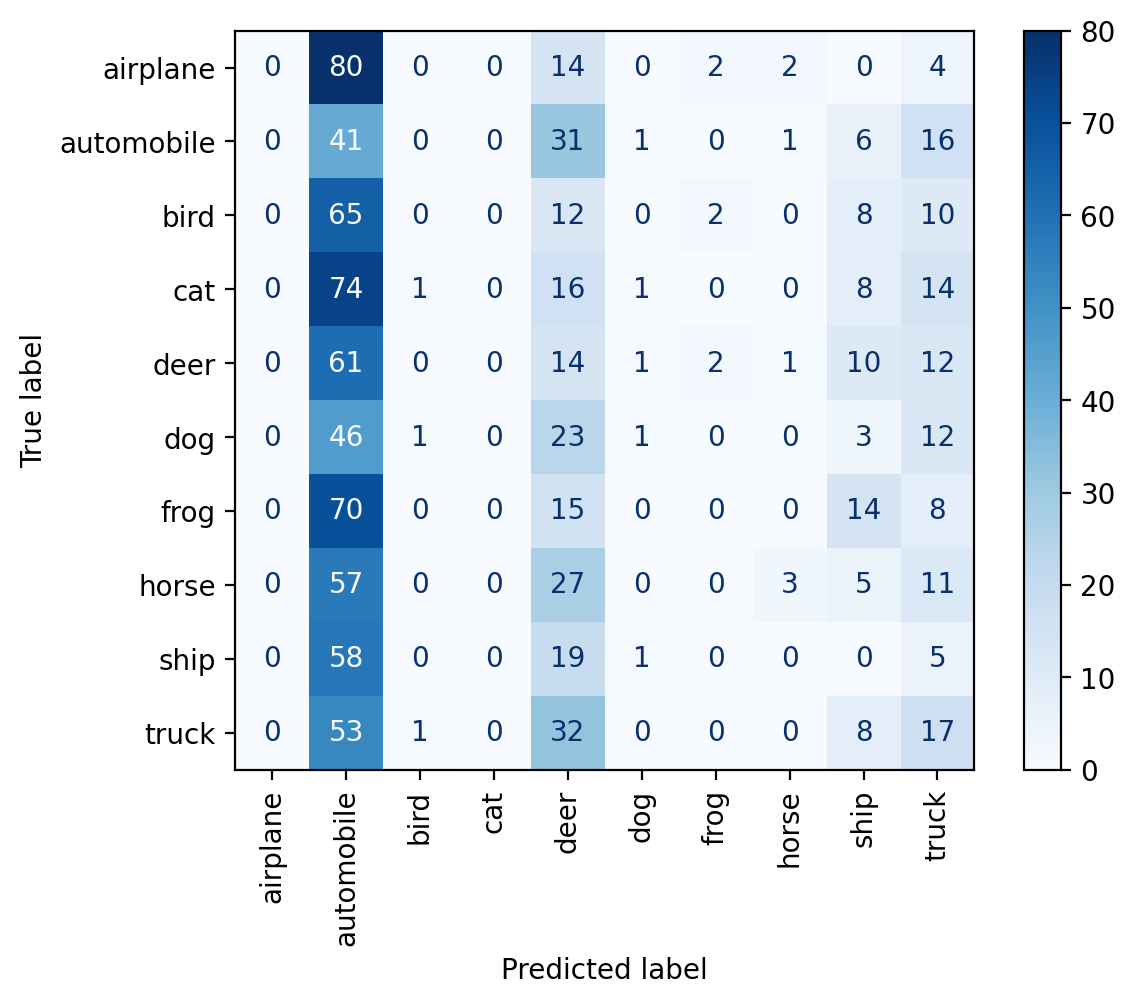

pool set accuracy: 7.25%


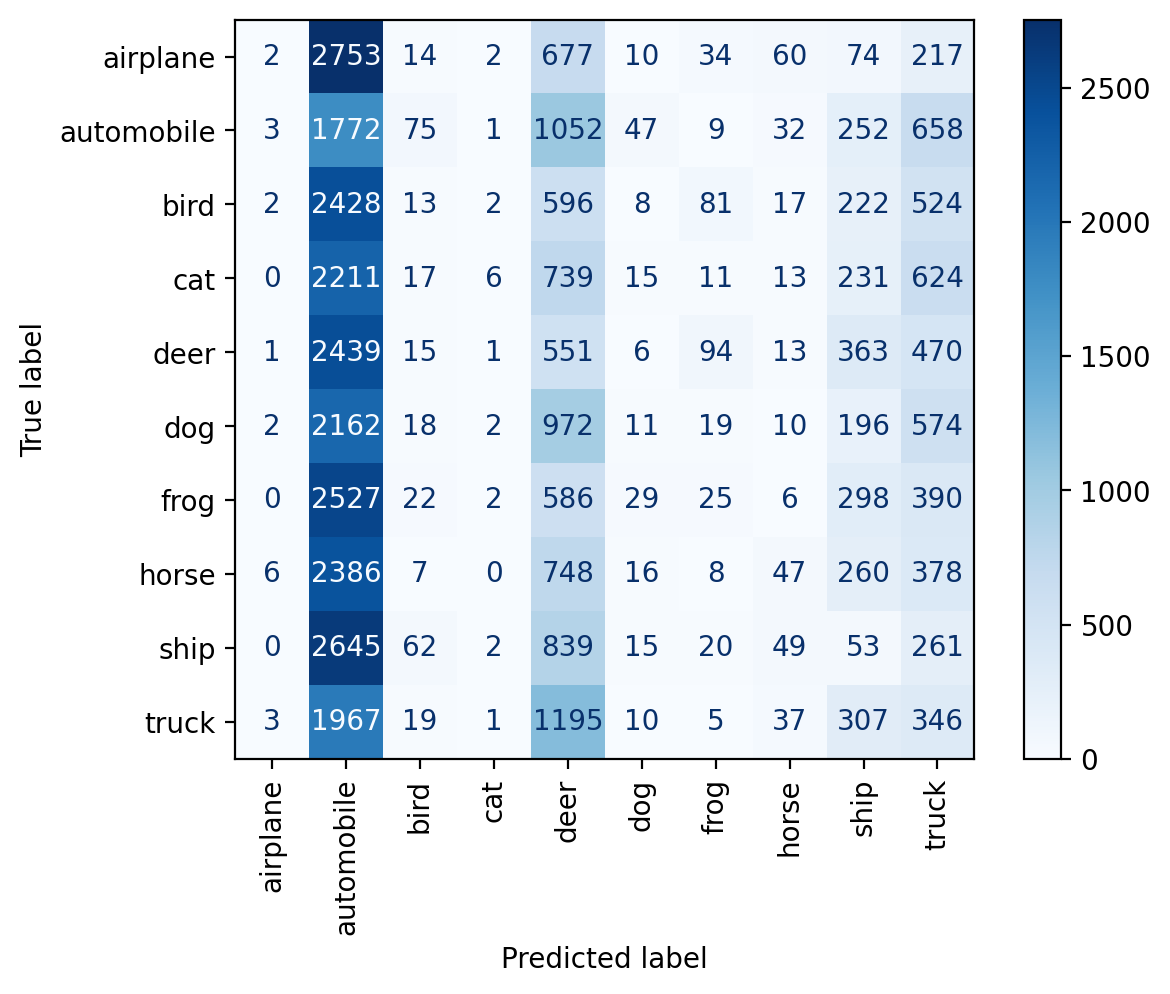

test set accuracy: 7.18%


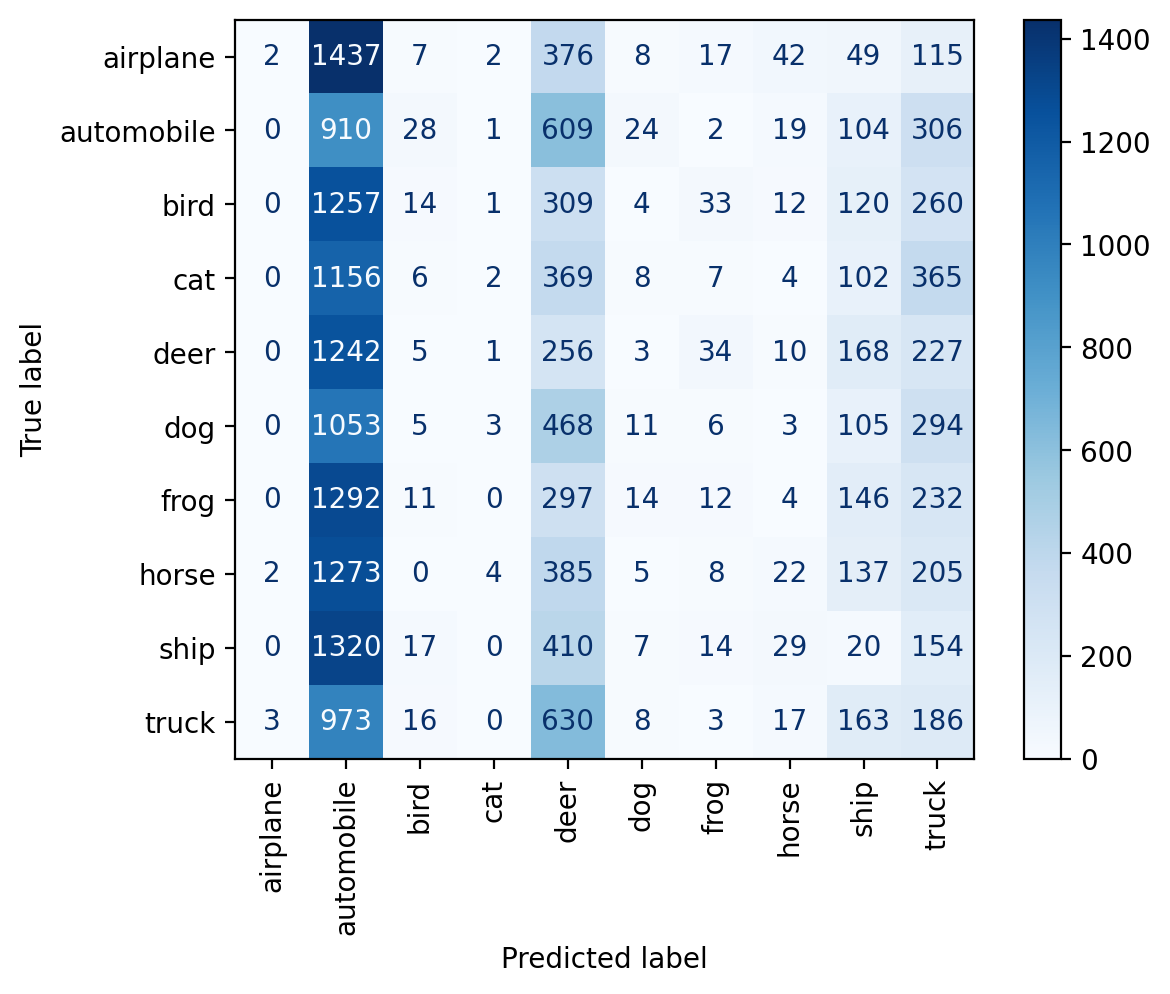

In [59]:
predict(resnet, dataset.classes, plot_confusion_matrix=True)

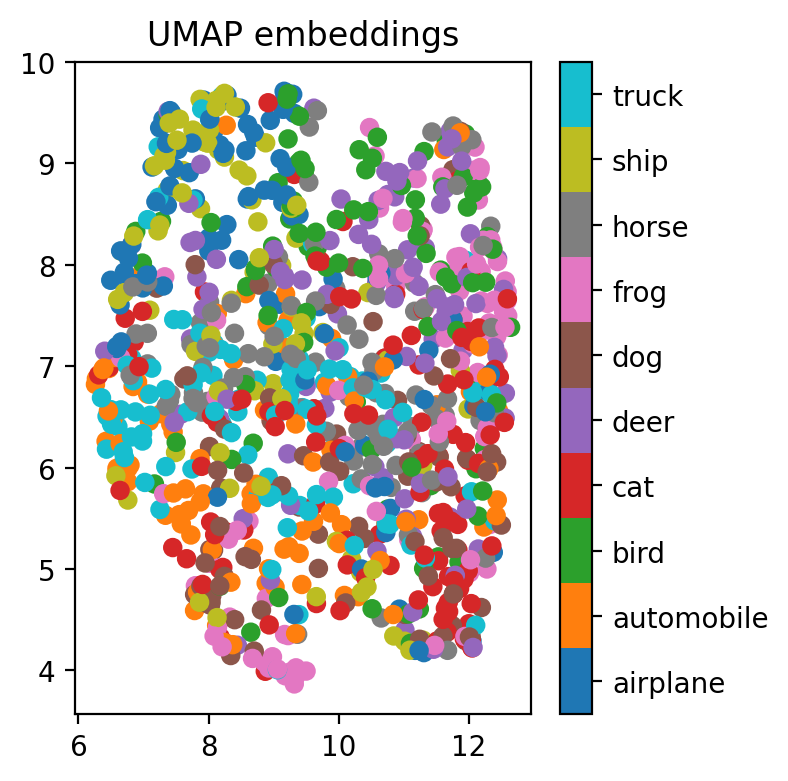

In [61]:
def viz_embeddings(net, X, y, device):
    reducer = umap.UMAP()
    with torch.no_grad():
        emb = net.featurizer(X.to(device))
    emb = emb.cpu().numpy()
    emb = reducer.fit_transform(emb)
    plt.figure(figsize=(4, 4))
    plt.scatter(emb[:, 0], emb[:, 1], c=y.cpu().numpy(), cmap='tab10')
    # Add a colorbar legend to mark color to class mapping
    cb = plt.colorbar(boundaries=np.arange(11)-0.5)
    cb.set_ticks(np.arange(10))
    cb.set_ticklabels(dataset.classes)
    plt.title("UMAP embeddings")
    plt.tight_layout()

viz_embeddings(resnet, X[train_idx], y[train_idx], device)

#### Train the model on train set

In [62]:
model_only_train = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)
iter_losses, epoch_losses = train_fn(model_only_train, X[train_idx], y[train_idx], nn.CrossEntropyLoss(), lr=3e-4, 
                                     batch_size=128, epochs=30, verbose=False)

Text(0, 0.5, 'Training loss')

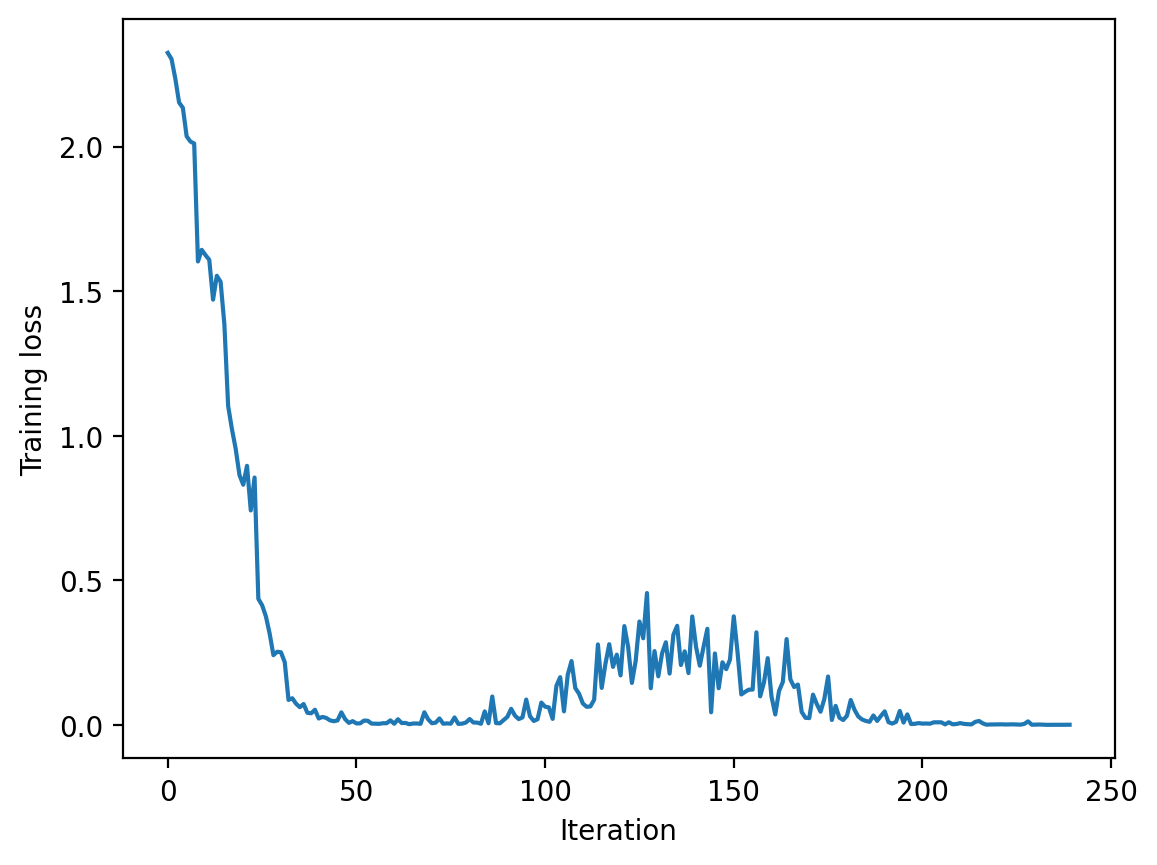

In [63]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

train set accuracy: 100.00%


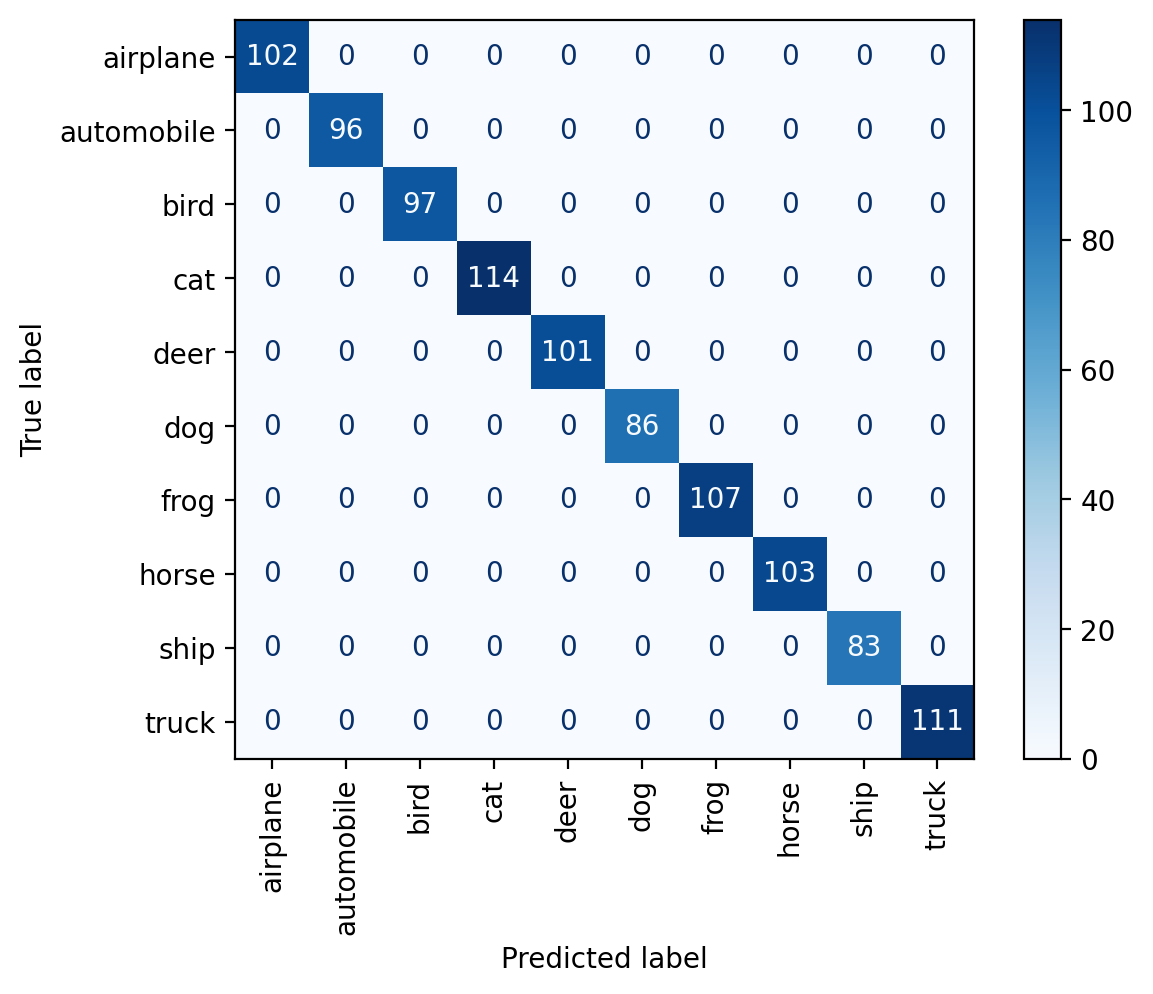

pool set accuracy: 36.59%


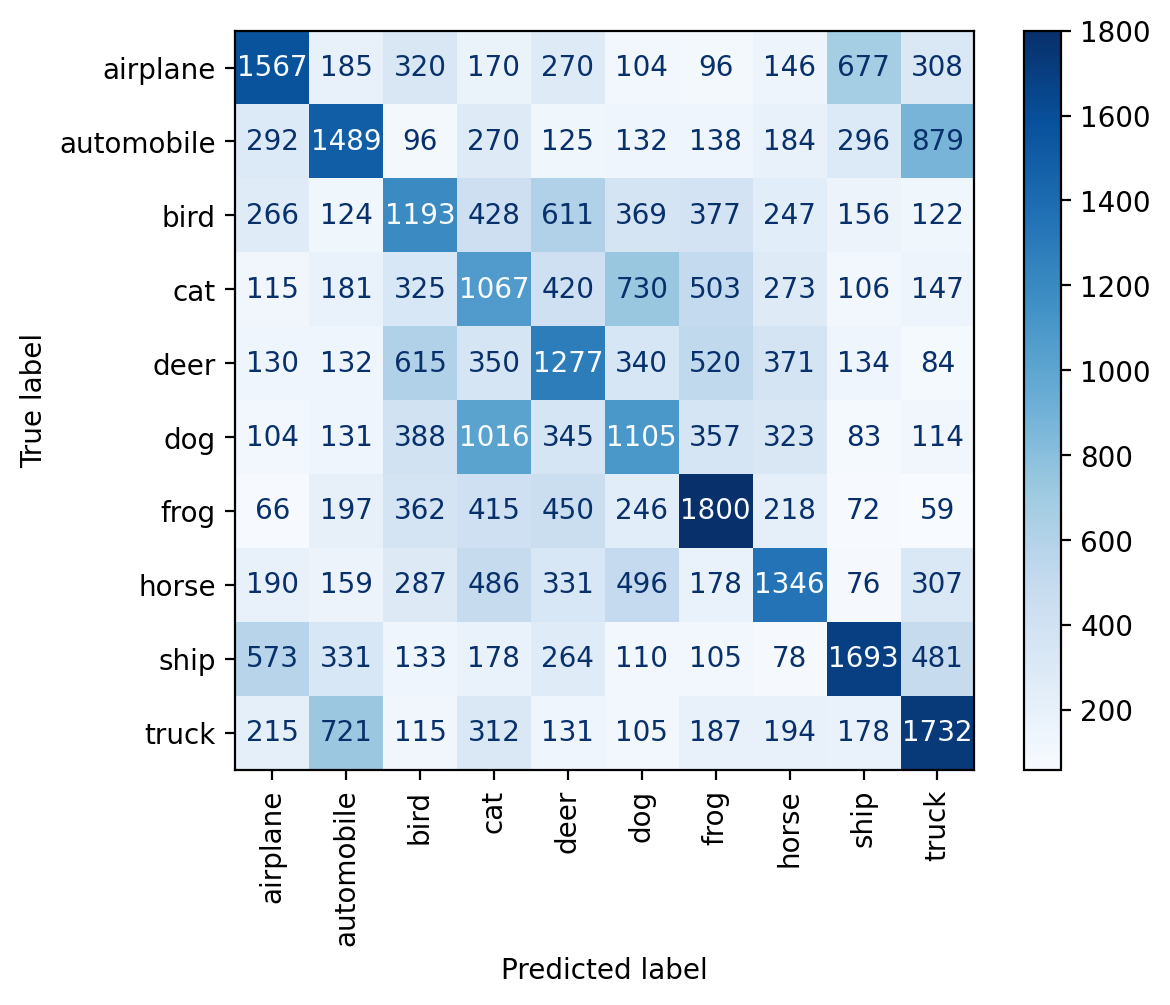

test set accuracy: 36.92%


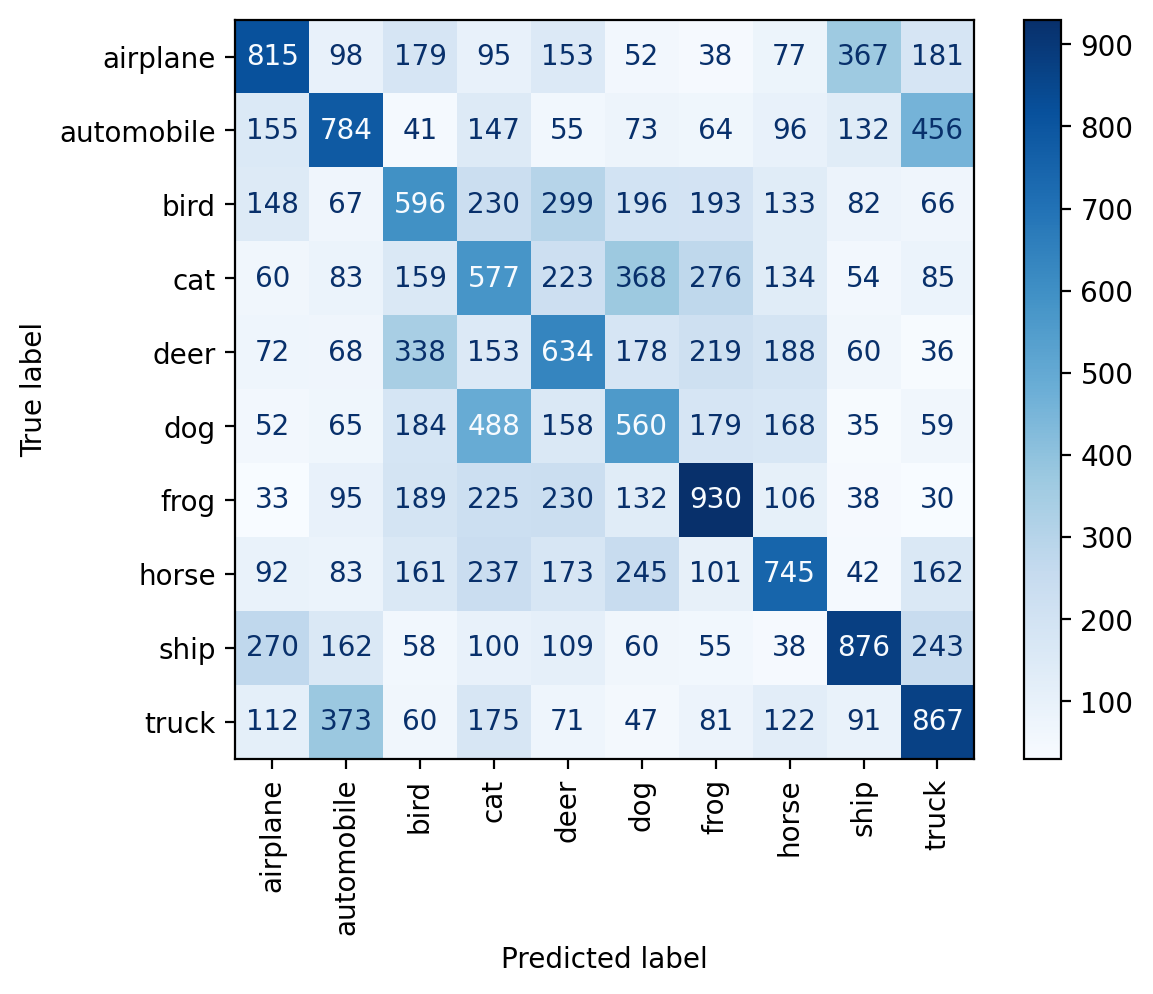

In [64]:
predict(model_only_train, dataset.classes, plot_confusion_matrix=True)

/home/nipun.batra/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


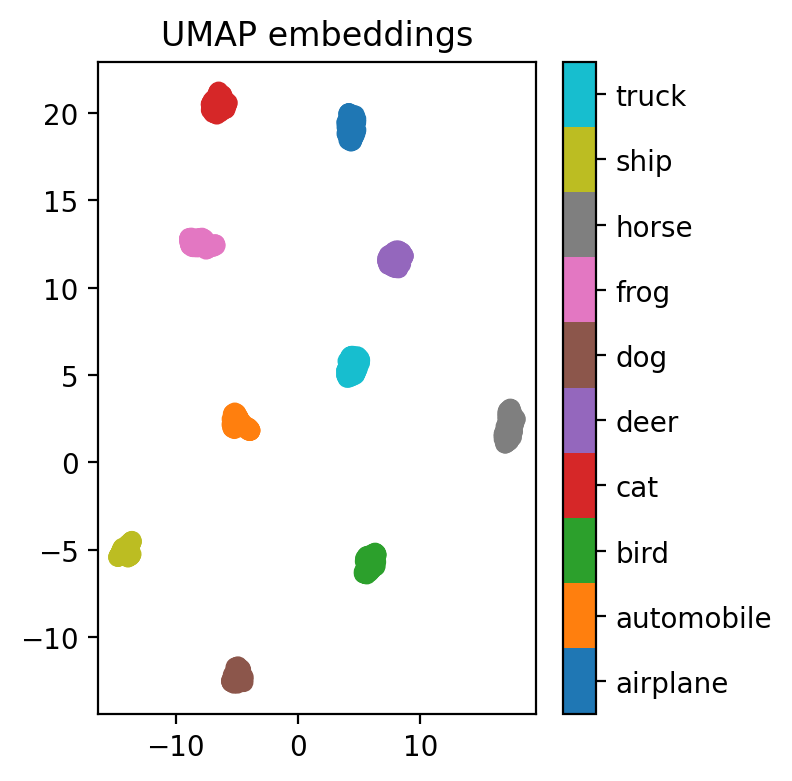

In [65]:
viz_embeddings(model_only_train, X[train_idx], y[train_idx], device)

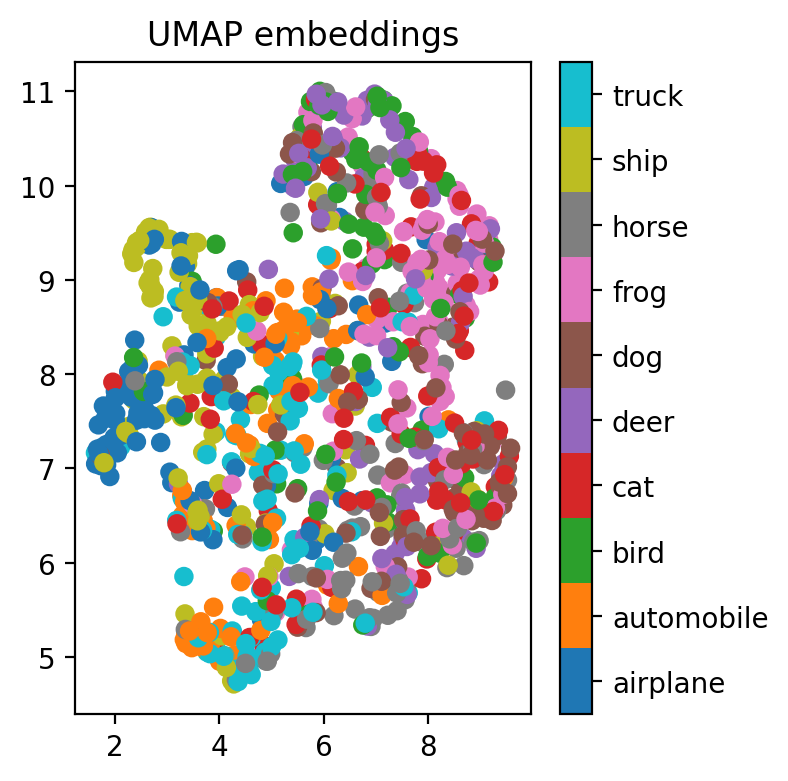

In [66]:
viz_embeddings(model_only_train, X[test_idx[:1000]], y[test_idx[:1000]], device)

### Train on train + pool


In [30]:
train_plus_pool_idx = torch.cat([train_idx, pool_idx])

model_train_plus_pool = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)

iter_losses, epoch_losses = train_fn(model_train_plus_pool, X[train_plus_pool_idx], y[train_plus_pool_idx], loss_fn=nn.CrossEntropyLoss(),
                                     lr=3e-4,
                                        batch_size=1024, epochs=30)

Loss: 1.401657: 100%|██████████| 40/40 [00:01<00:00, 33.22it/s]


Epoch 1: 1.6666034301757813


Loss: 1.337677: 100%|██████████| 40/40 [00:01<00:00, 35.31it/s]


Epoch 2: 1.2468693511962892


Loss: 0.778450: 100%|██████████| 40/40 [00:01<00:00, 35.94it/s]


Epoch 3: 1.0160566375732423


Loss: 1.019744: 100%|██████████| 40/40 [00:01<00:00, 36.40it/s]


Epoch 4: 0.8216809387207031


Loss: 0.768025: 100%|██████████| 40/40 [00:01<00:00, 36.51it/s]


Epoch 5: 0.6676962219238282


Loss: 0.406389: 100%|██████████| 40/40 [00:01<00:00, 36.03it/s]


Epoch 6: 0.5088176010131836


Loss: 0.115493: 100%|██████████| 40/40 [00:01<00:00, 35.25it/s]


Epoch 7: 0.37470185718536375


Loss: 0.463932: 100%|██████████| 40/40 [00:01<00:00, 36.26it/s]


Epoch 8: 0.21905497932434081


Loss: 0.387380: 100%|██████████| 40/40 [00:01<00:00, 36.30it/s]


Epoch 9: 0.3592237434387207


Loss: 0.111286: 100%|██████████| 40/40 [00:01<00:00, 35.80it/s]


Epoch 10: 0.21754123764038086


Loss: 0.121979: 100%|██████████| 40/40 [00:01<00:00, 35.93it/s]


Epoch 11: 0.11297036876678467


Loss: 0.147006: 100%|██████████| 40/40 [00:01<00:00, 36.16it/s]


Epoch 12: 0.10112307262420654


Loss: 0.253870: 100%|██████████| 40/40 [00:01<00:00, 36.82it/s]


Epoch 13: 0.10098845596313477


Loss: 0.223810: 100%|██████████| 40/40 [00:01<00:00, 35.69it/s]


Epoch 14: 0.19225826511383057


Loss: 0.069141: 100%|██████████| 40/40 [00:01<00:00, 36.32it/s]


Epoch 15: 0.1282618529319763


Loss: 0.155252: 100%|██████████| 40/40 [00:01<00:00, 34.95it/s]


Epoch 16: 0.054971636962890626


Loss: 0.110593: 100%|██████████| 40/40 [00:01<00:00, 35.56it/s]


Epoch 17: 0.09293806228637695


Loss: 0.088850: 100%|██████████| 40/40 [00:01<00:00, 34.35it/s]


Epoch 18: 0.0688858033657074


Loss: 0.072767: 100%|██████████| 40/40 [00:01<00:00, 35.32it/s]


Epoch 19: 0.05432000436782837


Loss: 0.055417: 100%|██████████| 40/40 [00:01<00:00, 36.87it/s]


Epoch 20: 0.07721749610900878


Loss: 0.050397: 100%|██████████| 40/40 [00:01<00:00, 36.16it/s]


Epoch 21: 0.05849722499847412


Loss: 0.255000: 100%|██████████| 40/40 [00:01<00:00, 36.81it/s]


Epoch 22: 0.06261234383583068


Loss: 0.154736: 100%|██████████| 40/40 [00:01<00:00, 35.98it/s]


Epoch 23: 0.15044091796875


Loss: 0.133806: 100%|██████████| 40/40 [00:01<00:00, 34.90it/s]


Epoch 24: 0.09881274623870849


Loss: 0.057377: 100%|██████████| 40/40 [00:01<00:00, 35.48it/s]


Epoch 25: 0.08926203842163086


Loss: 0.054785: 100%|██████████| 40/40 [00:01<00:00, 35.07it/s]


Epoch 26: 0.03692574572563172


Loss: 0.047962: 100%|██████████| 40/40 [00:01<00:00, 35.78it/s]


Epoch 27: 0.054436095714569095


Loss: 0.028603: 100%|██████████| 40/40 [00:01<00:00, 36.10it/s]


Epoch 28: 0.037155142211914065


Loss: 0.013970: 100%|██████████| 40/40 [00:01<00:00, 36.01it/s]


Epoch 29: 0.01886183919906616


Loss: 0.090528: 100%|██████████| 40/40 [00:01<00:00, 36.02it/s]


Epoch 30: 0.009831475555896758


Text(0, 0.5, 'Training loss')

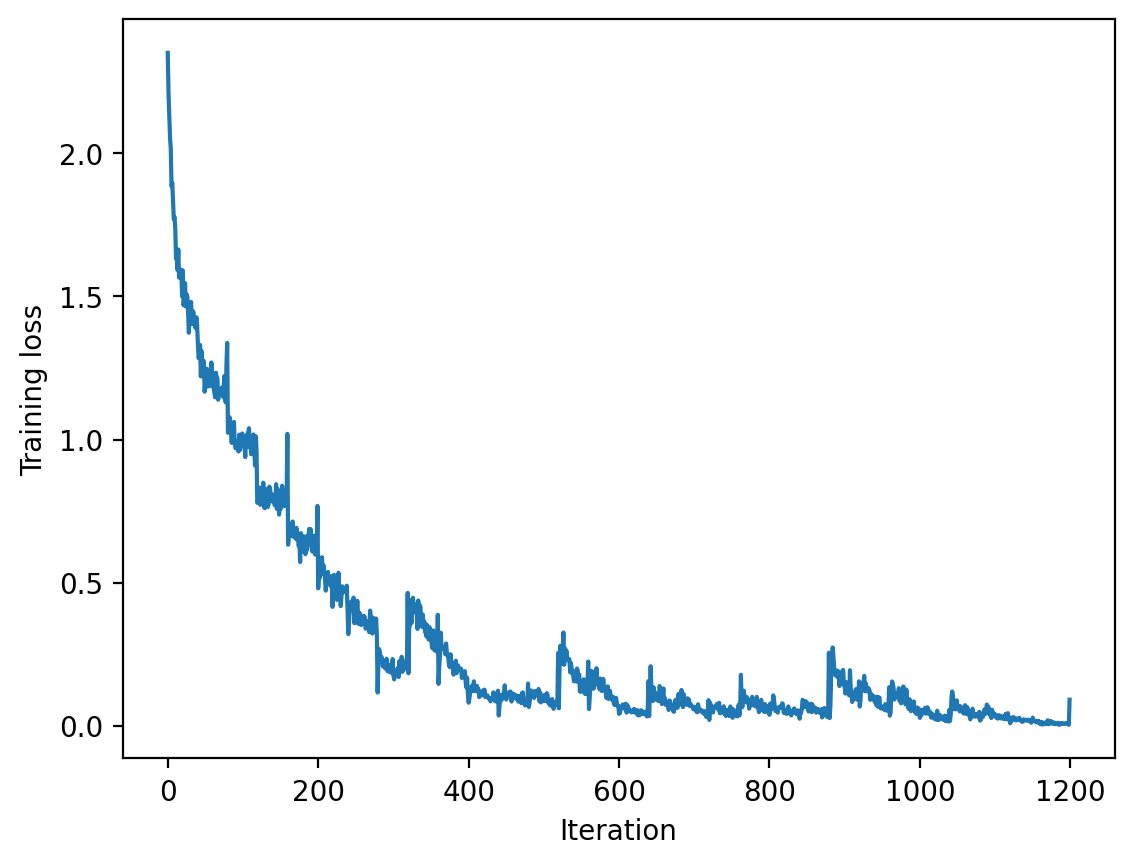

In [31]:
plt.plot(iter_losses)   
plt.xlabel("Iteration")
plt.ylabel("Training loss")

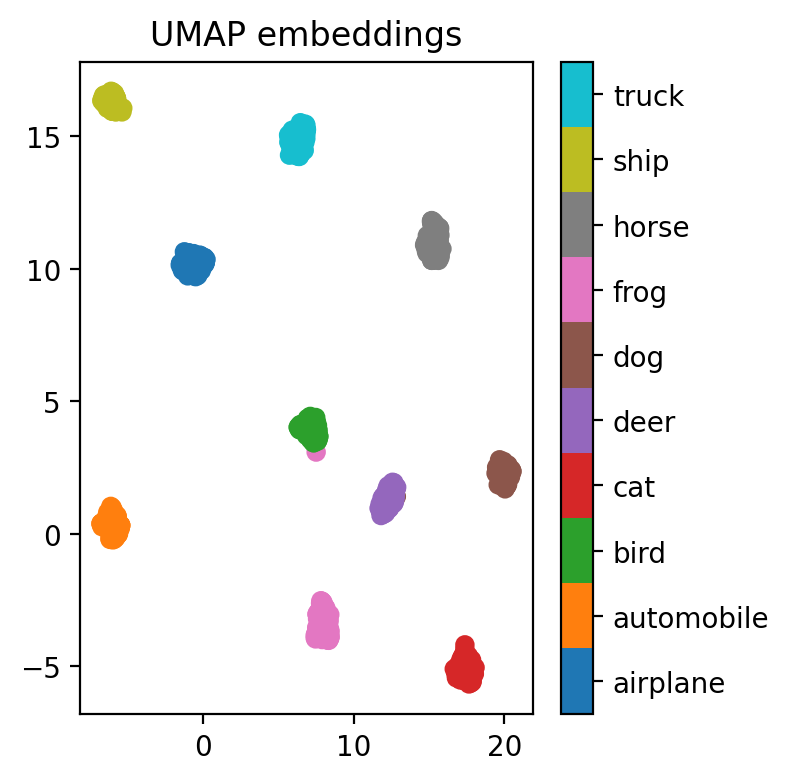

In [32]:
viz_embeddings(model_train_plus_pool, X[train_idx], y[train_idx], device)

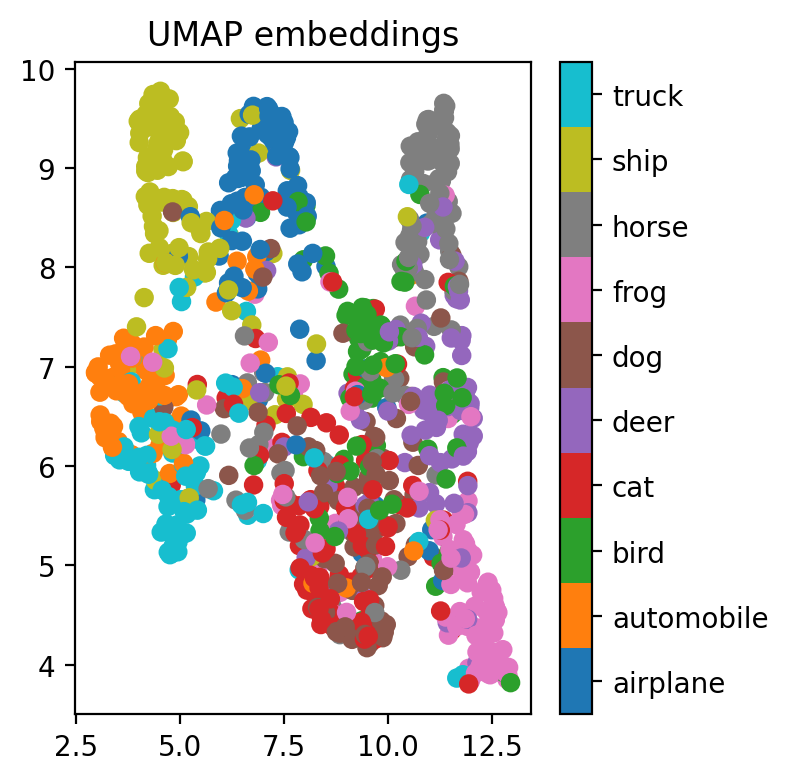

In [33]:
viz_embeddings(model_train_plus_pool, X[test_idx[:1000]], y[test_idx[:1000]], device)

train set accuracy: 99.40%


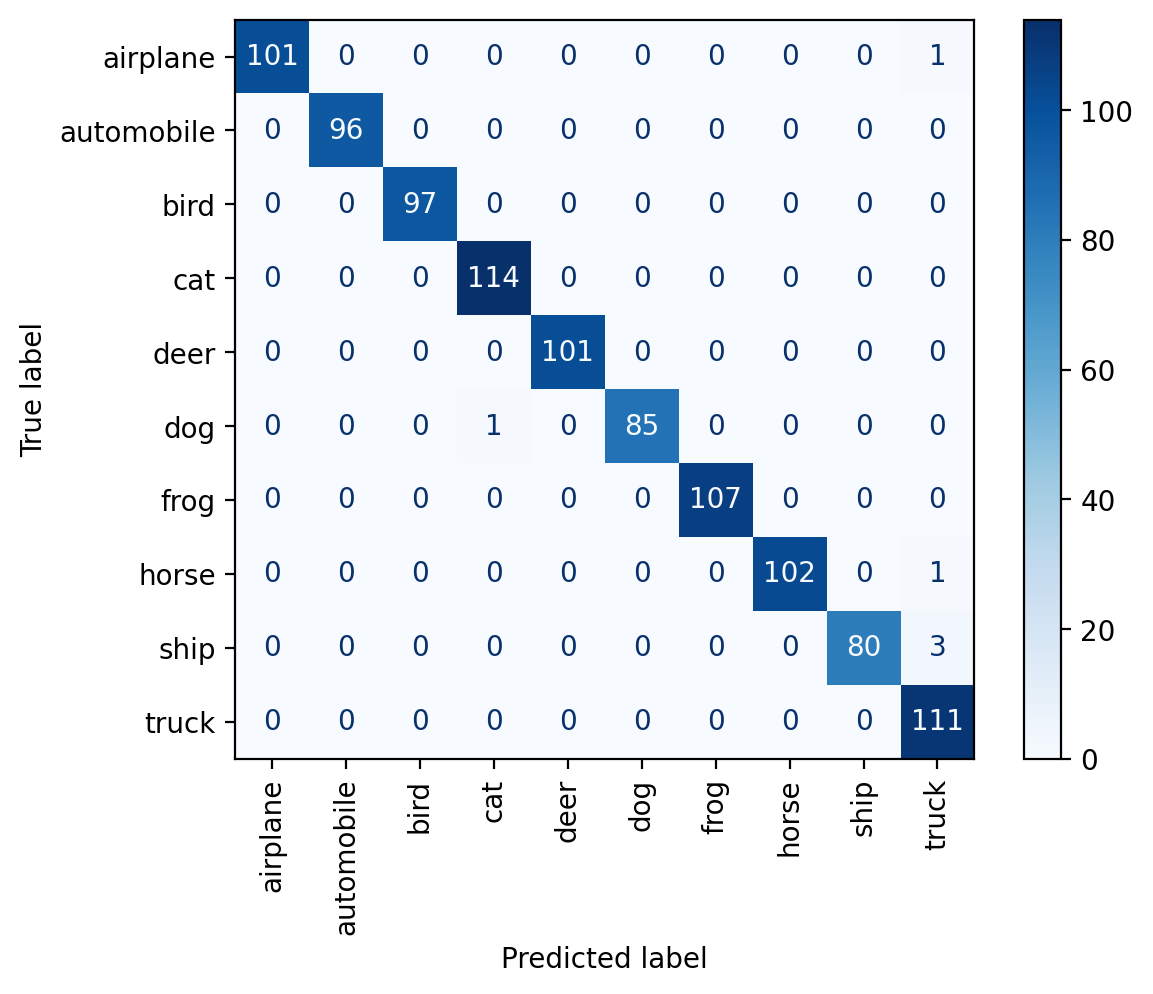

pool set accuracy: 99.38%


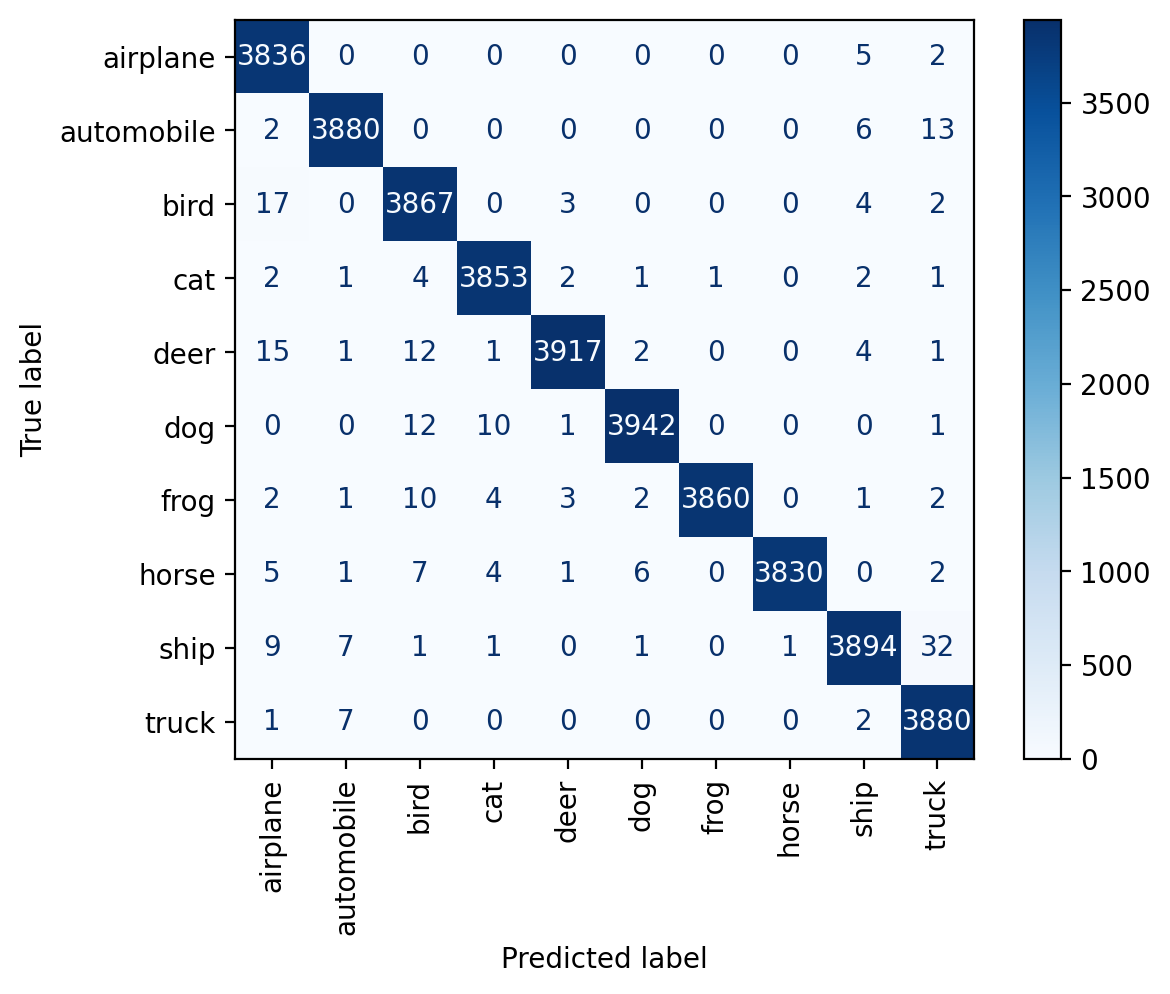

test set accuracy: 62.56%


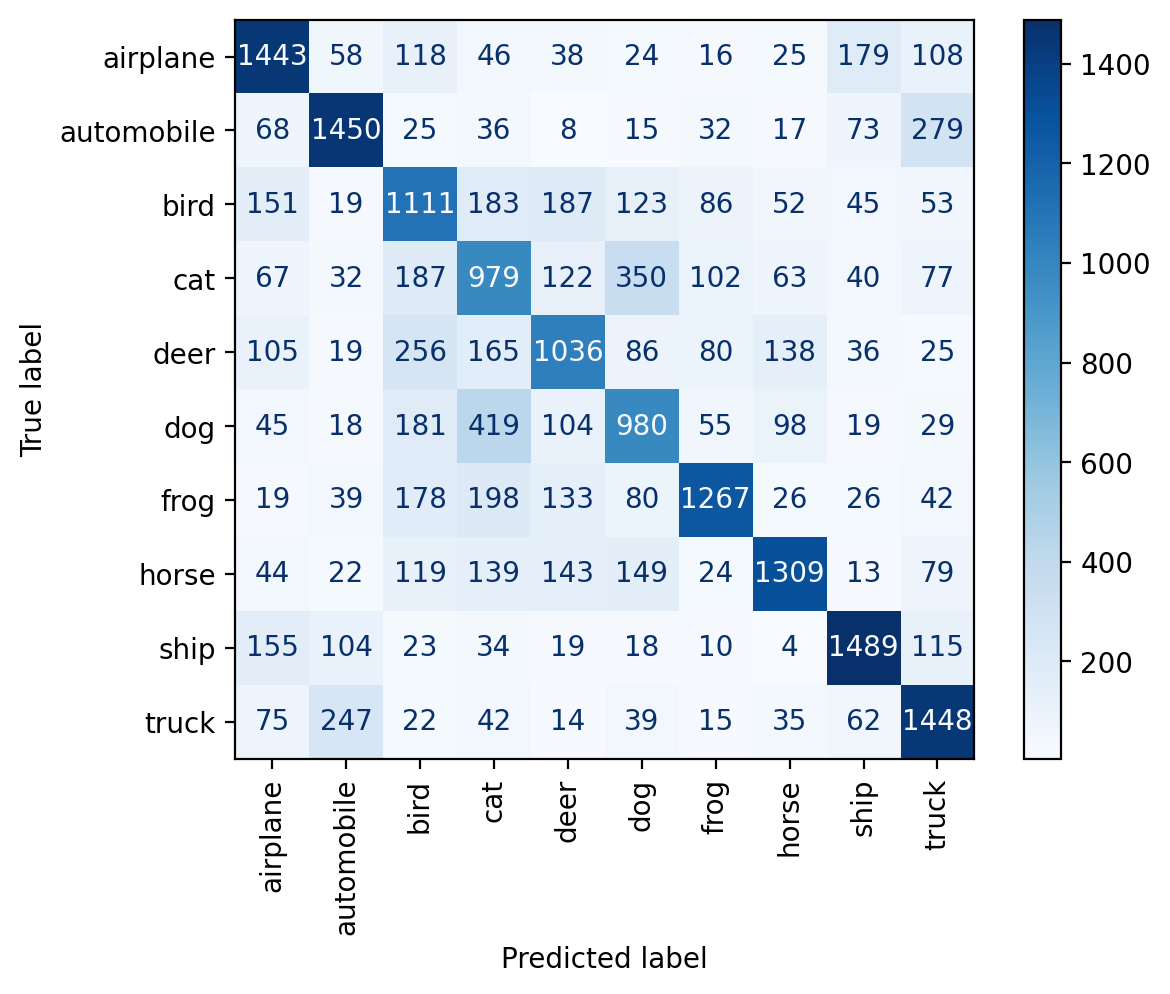

In [67]:
predict(model_train_plus_pool, dataset.classes, plot_confusion_matrix=True)

Text(0, 0.5, 'Accuracy')

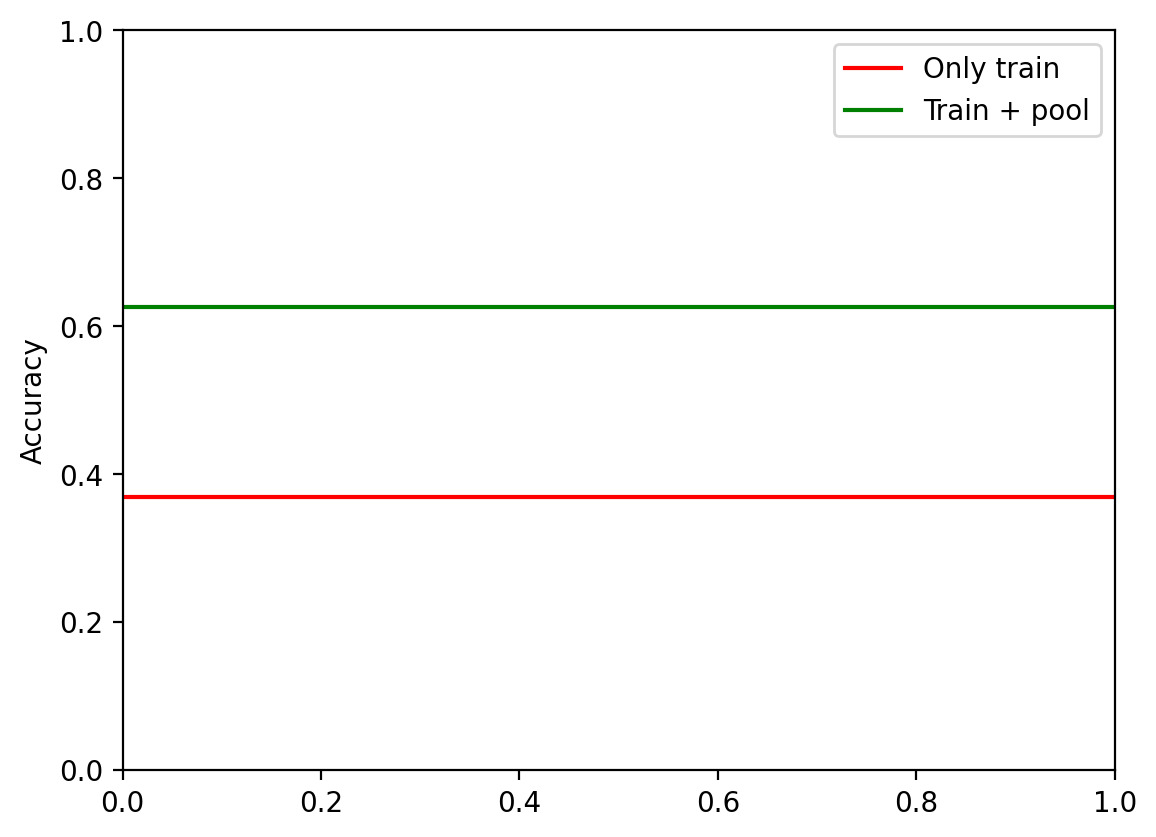

In [68]:
accuracy_only_train = get_accuracy(model_only_train, X[test_idx].to(device), y[test_idx].to(device))[1]
accuracy_train_plus_pool = get_accuracy(model_train_plus_pool, X[test_idx].to(device), y[test_idx].to(device))[1]

plt.axhline(accuracy_only_train.cpu(), color='r', label='Only train')
plt.axhline(accuracy_train_plus_pool.cpu(), color='g', label='Train + pool')
plt.legend()

plt.ylabel("Accuracy")

### Active learning loop



In [69]:
def setdiff1d(a, b):
    mask = ~a.unsqueeze(1).eq(b).any(dim=1)
    return torch.masked_select(a, mask)

a = torch.tensor([1, 2, 3, 4, 5])
b = torch.tensor([1, 3, 5])

print(setdiff1d(a, b))

a = torch.tensor([1, 2, 3, 4, 5])
b = torch.tensor([1, 2, 3, 4, 5])

print(setdiff1d(a, b))

tensor([2, 4])
tensor([], dtype=torch.int64)


In [70]:
def al_loop(model, query_strategy, num_al_iterations, num_epochs_finetune,
            train_idx, pool_idx, test_idx, query_size, 
            X, y, device, random_seed=0, verbose=False):
    """
    model: PyTorch model trained on train_idx
    query_strategy: function that takes in model and pool_idx, 
                train_idx and returns indices to query
    num_al_iterations: number of active learning iterations
    num_epochs_finetune: number of epochs to train on queried data + train_idx
    train_idx: indices of data used for training
    pool_idx: indices of data used for querying
    test_idx: indices of data used for testing
    query_size: number of data points to query at each iteration
    X: data
    y: labels
    device: torch device
    random_seed: random seed
    verbose: print statements
    """
    tr_idx = train_idx.clone()
    p_idx = pool_idx.clone()
    torch.manual_seed(random_seed)
    
    print(f"Initial train size: {train_idx.shape}")
    print(f"Initial pool size: {pool_idx.shape}")
    
    # Initial model test accuracy
    init_accuracy = get_accuracy(model, X[test_idx].to(device), y[test_idx].to(device))[1].item()
    print(f"Test accuracy before AL: {init_accuracy:0.4f}")
    
    # Test accuracies
    test_accuracies = {0: init_accuracy}
    
    for iteration in range(num_al_iterations):
        
        # Query
        model.eval()
        query_idx = query_strategy(model, p_idx, tr_idx, random_seed, query_size, X, y, device)
        # Add queried data to train_idx
        tr_idx = torch.cat([tr_idx, query_idx])
        # Remove queried data from pool_idx
        p_idx = setdiff1d(p_idx, query_idx)
        # Retrain model on pooled data
        iter_losses, epoch_losses = train_fn(model, X[tr_idx], y[tr_idx], loss_fn=nn.CrossEntropyLoss(),
                                             lr=3e-4, batch_size=1024,
                                             epochs=num_epochs_finetune, 
                                             verbose=False)
        test_accuracies[iteration+1] = get_accuracy(model, X[test_idx].to(device), y[test_idx].to(device))[1].item()
        if verbose:
            print(f"Active learning iteration {iteration+1}/{num_al_iterations}")
            print(f"Train set size: {len(tr_idx)}, Pool set size: {len(p_idx)}")
            print(f"Test accuracy: {test_accuracies[iteration]:0.4f}")
            print()
    return model, tr_idx, p_idx, test_accuracies      
    

In [71]:
def random_sampling(model, pool_idx, train_idx, random_seed, query_size, X, y, device):
    torch.manual_seed(random_seed)
    query_idx = pool_idx[torch.randperm(len(pool_idx))[:query_size]]
    return query_idx


In [74]:
query_size = 100
num_al_iterations = 50

In [75]:

import copy

model_r = copy.deepcopy(model_only_train)

model, t_idx, p_idx, test_acc_random = al_loop(model_r, random_sampling, num_al_iterations, 20, train_idx, pool_idx, test_idx, query_size, X, y,device=device,verbose=True)

Initial train size: torch.Size([1000])
Initial pool size: torch.Size([39000])
Test accuracy before AL: 0.3692
Active learning iteration 1/50
Train set size: 1100, Pool set size: 38900
Test accuracy: 0.3692

Active learning iteration 2/50
Train set size: 1200, Pool set size: 38800
Test accuracy: 0.3385

Active learning iteration 3/50
Train set size: 1300, Pool set size: 38700
Test accuracy: 0.3677

Active learning iteration 4/50
Train set size: 1400, Pool set size: 38600
Test accuracy: 0.3746

Active learning iteration 5/50
Train set size: 1500, Pool set size: 38500
Test accuracy: 0.3832

Active learning iteration 6/50
Train set size: 1600, Pool set size: 38400
Test accuracy: 0.3963

Active learning iteration 7/50
Train set size: 1700, Pool set size: 38300
Test accuracy: 0.3938

Active learning iteration 8/50
Train set size: 1800, Pool set size: 38200
Test accuracy: 0.4047

Active learning iteration 9/50
Train set size: 1900, Pool set size: 38100
Test accuracy: 0.4165

Active learning i

<AxesSubplot:>

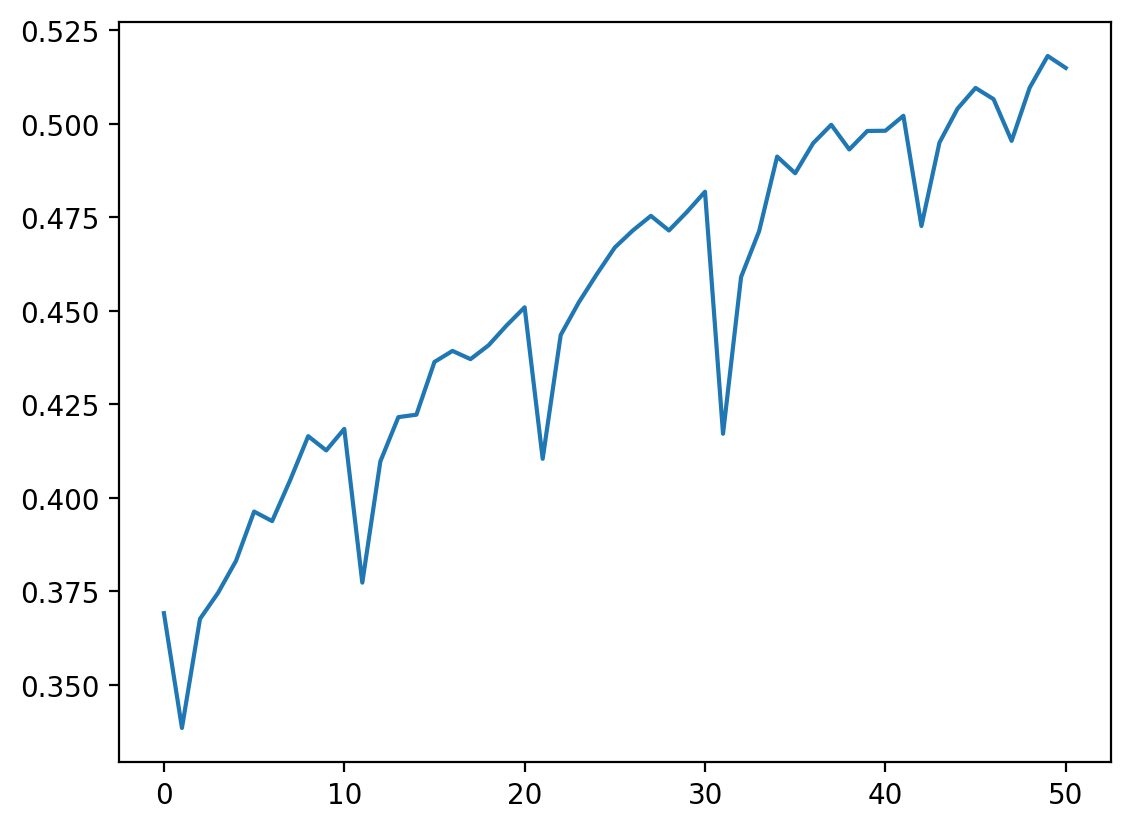

In [76]:
pd.Series(test_acc_random).plot()

In [154]:
### Now, running across multiple random seeds

query_size = 100
num_al_iterations = 30
ms = {}
t_idxs = {}
p_idxs = {}
test_acc_random = {}
for rs in range(5):
    print(f"Random seed: {rs}")
    model = copy.deepcopy(model_only_train)
    ms[rs], t_idxs[rs], p_idxs[rs], test_acc_random[rs] = al_loop(model, random_sampling, num_al_iterations, 30, train_idx, pool_idx, test_idx, query_size, X, y,device=device,verbose=False, random_seed=rs)


Random seed: 0


KeyboardInterrupt: 

In [116]:
test_acc_random_df = pd.DataFrame(test_acc_random)
mean_acc = test_acc_random_df.mean(axis=1)
std_acc = test_acc_random_df.std(axis=1)

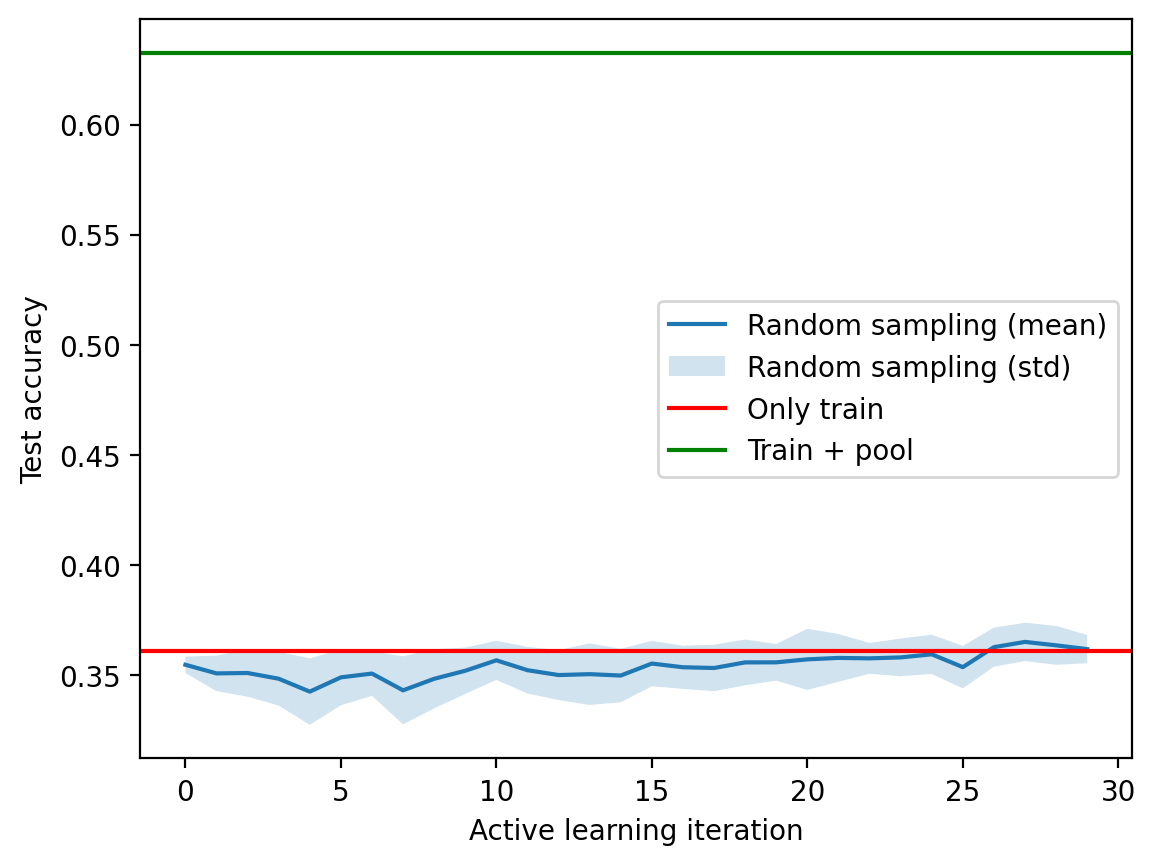

In [157]:
plt.plot(mean_acc, label="Random sampling (mean)")
plt.fill_between(mean_acc.index, mean_acc-std_acc,
                 mean_acc+std_acc, alpha=0.2, label="Random sampling (std)")

# Accuracy of model trained on train_idx
plt.axhline(accuracy_only_train.cpu(), color='r', label='Only train')

# Accuracy of model trained on train_idx + pool_idx
plt.axhline(accuracy_train_plus_pool.cpu(), color='g', label='Train + pool')
plt.xlabel("Active learning iteration")
plt.ylabel("Test accuracy")
plt.legend()

In [77]:
def entropy_sampling(model, pool_idx, train_idx, random_seed, query_size, X, y, device):
    torch.manual_seed(random_seed)
    with torch.no_grad():
        logits = model(X[pool_idx].to(device))    
        probs = F.softmax(logits, dim=1)
        entropy = torch.sum(-probs * torch.log(probs), dim=1)
        entropy_sorted = entropy.sort(descending=True)
        query_idx = pool_idx.to(device)[entropy_sorted.indices[:query_size]]
    return query_idx.cpu()

In [78]:
entropy_sampling(model_only_train, pool_idx, train_idx, 0, 5, X, y, device)

tensor([  735, 22109, 50820, 21523, 46551])

In [79]:
model_e = copy.deepcopy(model_only_train)
# AL loop

m, p_idx, t_idx, test_acc_entropy  = al_loop(model_e, entropy_sampling, num_al_iterations, 20, train_idx, pool_idx, test_idx, query_size, 
                                             X, y,device=device,verbose=True, random_seed=0)

Initial train size: torch.Size([1000])
Initial pool size: torch.Size([39000])
Test accuracy before AL: 0.3692
Active learning iteration 1/50
Train set size: 1100, Pool set size: 38900
Test accuracy: 0.3692

Active learning iteration 2/50
Train set size: 1200, Pool set size: 38800
Test accuracy: 0.3384

Active learning iteration 3/50
Train set size: 1300, Pool set size: 38700
Test accuracy: 0.3700

Active learning iteration 4/50
Train set size: 1400, Pool set size: 38600
Test accuracy: 0.3668

Active learning iteration 5/50
Train set size: 1500, Pool set size: 38500
Test accuracy: 0.3874

Active learning iteration 6/50
Train set size: 1600, Pool set size: 38400
Test accuracy: 0.3890

Active learning iteration 7/50
Train set size: 1700, Pool set size: 38300
Test accuracy: 0.4050

Active learning iteration 8/50
Train set size: 1800, Pool set size: 38200
Test accuracy: 0.3919

Active learning iteration 9/50
Train set size: 1900, Pool set size: 38100
Test accuracy: 0.3932

Active learning i

<AxesSubplot:>

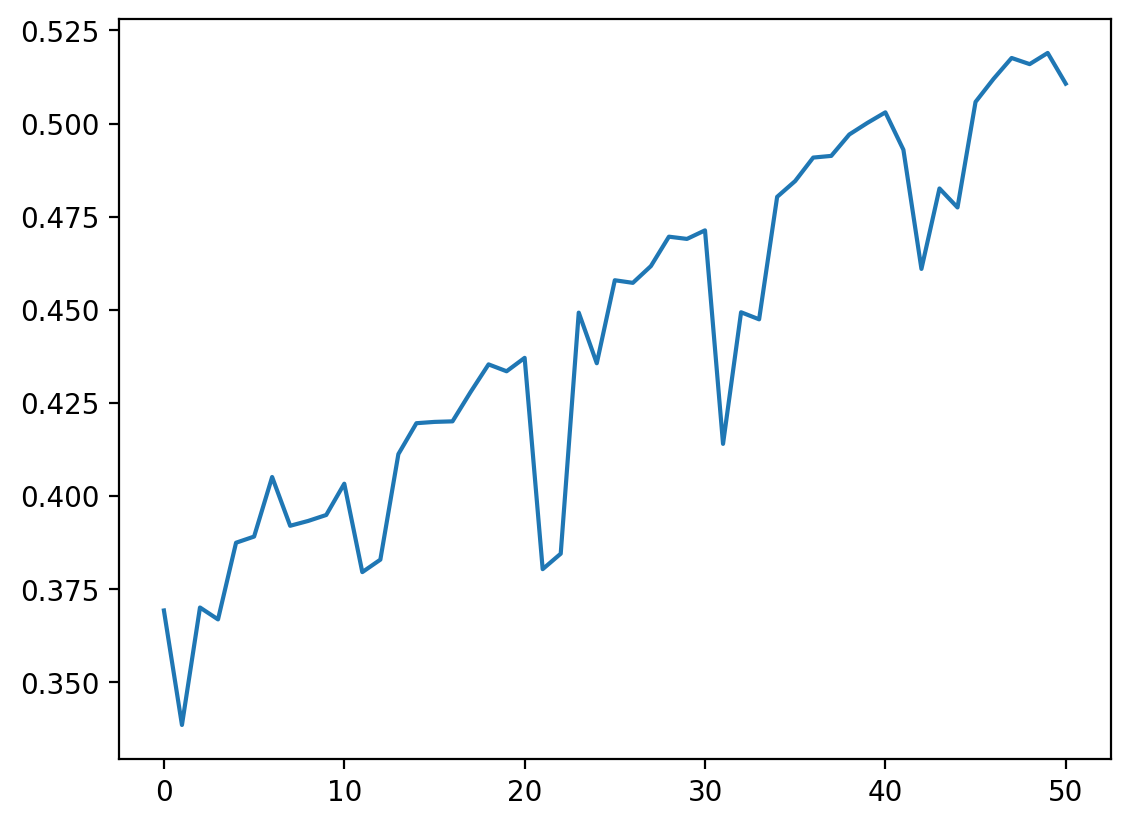

In [80]:
pd.Series(test_acc_entropy).plot()

In [51]:
def margin_sampling(model, pool_idx, train_idx, random_seed, query_size, X, y, device):
    torch.manual_seed(random_seed)
    with torch.no_grad():
        logits = model(X[pool_idx].to(device))    
        probs = F.softmax(logits, dim=1)
        margin = torch.topk(probs, 2, dim=1).values
        margin = margin[:, 0] - margin[:, 1]
        margin_sorted = margin.sort(descending=True)
        query_idx = pool_idx.to(device)[margin_sorted.indices[:query_size]]
    return query_idx.cpu()

In [52]:
margin_sampling(model_only_train, pool_idx, train_idx, 0, 5, X, y, device)

tensor([ 4108, 21206,  6416, 23325, 47390])

In [53]:
def diversity_sampling(model, pool_idx, train_idx, random_seed, query_size, X, y, device):
    torch.manual_seed(random_seed)
    with torch.no_grad():
        emb_pool = model.featurizer(X[pool_idx].to(device))
        emb_train = model.featurizer(X[train_idx].to(device))
        # Find the distance between each pool point and each train point
        dist = torch.cdist(emb_pool, emb_train)
        print(dist.shape)
        # Find the minimum distance for each pool point
        min_dist = dist.min(dim=1).values
        print(min_dist)
        # Sort the pool points by minimum distance
        min_dist_sorted = min_dist.sort(descending=True)
        query_idx = pool_idx.to(device)[min_dist_sorted.indices[:query_size]]
    return query_idx.cpu()
        

In [54]:
diversity_sampling(model_only_train, pool_idx, train_idx, 0, 5, X, y, device)

torch.Size([39000, 1000])
tensor([25.3104, 21.1980, 21.8605,  ..., 26.1072, 19.5255, 19.3866],
       device='cuda:0')


tensor([53343, 31728,  7260, 59899, 52004])

In [ ]:
BALD sample dataset to illustrate the idea



In [97]:
def BALD_score(logits):
    """
    logits: (n_MC_passes, n_samples, n_classes)
    """
    probs = F.softmax(logits, dim=2)
    expected_probs = probs.mean(dim=0) # Expectation over MC passes
    print(probs.shape)
    print(expected_probs.shape)
    entropy_expected_probs = torch.sum(-expected_probs * torch.log(expected_probs), dim=1)
    print(entropy_expected_probs.shape)
    
    entropy_probs = torch.sum(-probs * torch.log(probs), dim=2)
    print(entropy_probs.shape)
    expected_entropy_probs = entropy_probs.mean(dim=0)
    print(expected_entropy_probs.shape)
    
    bald_score = entropy_expected_probs - expected_entropy_probs
    print(bald_score.shape)
    return bald_score

In [98]:
s = BALD_score(z)

torch.Size([8, 39000, 10])
torch.Size([39000, 10])
torch.Size([39000])
torch.Size([8, 39000])
torch.Size([39000])
torch.Size([39000])


(array([2.4955e+04, 7.2480e+03, 3.9930e+03, 1.7060e+03, 6.6900e+02,
        2.7900e+02, 9.5000e+01, 3.6000e+01, 1.2000e+01, 7.0000e+00]),
 array([-6.6037728e-08,  8.5646212e-03,  1.7129309e-02,  2.5693996e-02,
         3.4258682e-02,  4.2823371e-02,  5.1388059e-02,  5.9952747e-02,
         6.8517432e-02,  7.7082120e-02,  8.5646808e-02], dtype=float32),
 <BarContainer object of 10 artists>)

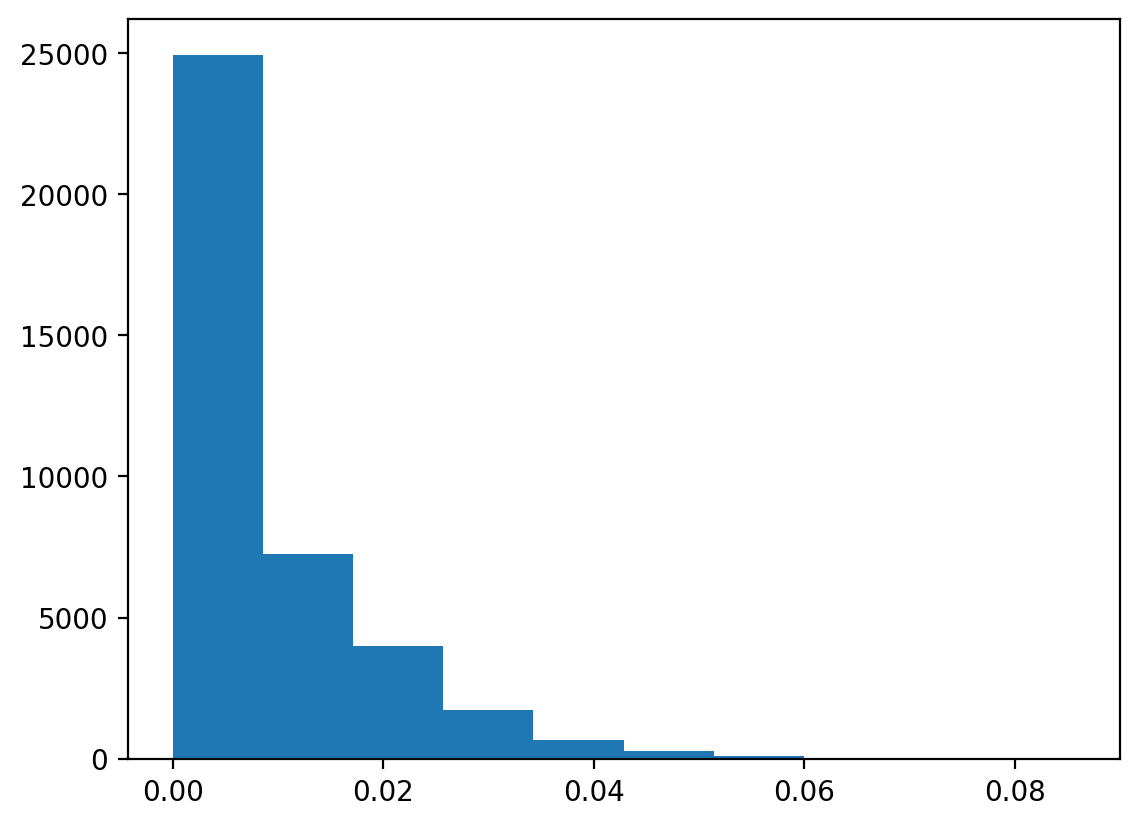

In [101]:
plt.hist(s.cpu().numpy())

In [89]:
def BALD_sampling(model, pool_idx, train_idx, random_seed, query_size, X, y, device):
    """
    model: MC dropout model
    """
    
    # Evaluate the logits on the pool set for each MC pass
    n_MC_passes = 8
    logits = []
    model.train()
    with torch.no_grad():
        for mc_pass in range(n_MC_passes):
            # Set mode of model for MC dropout
            logits.append(model(X[pool_idx].to(device)))
    logits = torch.stack(logits)
    print(logits.shape)
    return logits

In [90]:
z = BALD_sampling(model_only_train, pool_idx, train_idx, 0, 5, X, y, device)

torch.Size([8, 39000, 10])


In [57]:
z

tensor([[[ 0.3388, -2.1234, -2.3473,  ..., -2.1281, -0.4217, 12.7896],
         [ 0.8292, -4.5763,  6.0699,  ..., -2.5494, -2.7480, -2.8408],
         [ 5.2449, -3.0795,  4.4989,  ..., -1.9079,  2.9052, -3.1145],
         ...,
         [ 5.3315,  2.3735, -6.2679,  ...,  0.7474, -0.8667,  6.2138],
         [ 1.5080, -5.9996,  3.2538,  ..., -4.0376, -2.4181, -3.6527],
         [-2.9643,  0.4283,  0.9432,  ..., -3.0817, -0.6991, -0.4156]],

        [[ 0.1567, -1.7706, -2.4705,  ..., -2.6329,  0.1972, 13.8623],
         [-0.0747, -5.1044,  6.3982,  ..., -3.5493, -1.6399, -2.9734],
         [ 4.2921, -3.3327,  3.8348,  ..., -1.9648,  2.7953, -2.9115],
         ...,
         [ 5.0490,  1.9400, -6.2726,  ...,  1.1649, -0.5666,  5.9360],
         [ 1.5845, -6.3878,  3.3166,  ..., -4.4114, -2.1701, -4.1192],
         [-2.9213,  0.8033,  1.2228,  ..., -3.6955, -1.1070,  0.3713]],

        [[ 0.4457, -2.3014, -2.3532,  ..., -2.0336,  0.9234, 12.2555],
         [ 0.0508, -5.2943,  5.4812,  ..., -3